In [3]:
# torch 
import torch

# utils
import os
import numpy as np
import argparse

# statistics & visualization
import matplotlib.pyplot as plt

# model & dataset
from LALip.model.densenet_3d import DenseNet3D
from dataset import dataset

# evaluation
from metric.WERandCERmetrics import CalculateErrorRate
from LALip.misc import idx2text, ctc_decoder, plot_error_curves_comparison

In [4]:
def evaluate(model, valid_loader, device, epoch):
    model.eval()

    with torch.no_grad():
        # initialize
        eval_loss = []
        eval_WER = []
        eval_CER = []
        
        criterion = torch.nn.CTCLoss()

        for _, (video, label, video_length, label_length) in enumerate(valid_loader):
            if video is None:
                continue
            video, label, video_length, label_length = video.to(device), label.to(device), video_length.to(device), label_length.to(device)
            output = model(video)

            # calculate loss
            loss = criterion(output.log_softmax(-1).transpose(0,1), label, video_length.view(-1), label_length.view(-1))
            eval_loss.append(loss.detach().cpu().numpy())

            pred_text = ctc_decoder(output)
            gt_text = []
            for _ in range(len(label)):
                gt_text.append(idx2text(label[_]))
            
            # calculate WER and CER
            wer = CalculateErrorRate(gt_text[0], pred_text[0], method='WER')
            cer = CalculateErrorRate(gt_text[0], pred_text[0], method='CER')
            eval_WER.append(wer)
            eval_CER.append(cer)

            mean_WER = np.mean(np.array(eval_WER))
            mean_CER = np.mean(np.array(eval_CER))
        
        # print statistics
        print('Evaluation Loss: {:.3f}, eval WER: {:.3f}, eval CER: {:.3f}'.format(epoch+1, np.mean(np.array(eval_loss)), mean_WER, mean_CER))


In [8]:
def train(rnn):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("device: ", device)

    # load data
    train_loader, valid_loader = dataset.get_dataloaders(root_path='/data/ziruiw3/lip_reading/frames/',
                                                         batch_size=64,
                                                         split=0.8,
                                                         shuffle=True,
                                                         num_workers=0,
                                                         pin_memory=False)
    print("data loaded")

    # ---- training 3D CNN + GRU -----
    # load model
    model = DenseNet3D(rnn)
    model.to(device)
    criterion = torch.nn.CTCLoss()                                  # loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)    # optimizer
    print("model loaded")
    model.train() 

    # training
    WER = []
    CER = []
    losses = []
    iteration = 0
    print("start training...")
    for epoch in range(10):
        model.train()
        for _, (video, label, video_length, label_length) in enumerate(train_loader):

            if video is None: # some videos have incorrect number of frames, skip them (see collate_fn in dataset.py)
                continue

            # reset gradients
            optimizer.zero_grad()

            # load data to GPU
            video, label,video_length, label_length = video.to(device), label.to(device), video_length.to(device), label_length.to(device)

            # forward 
            output = model(video)   #(T, B, C, H, W) -> (B, T, Emb=28) (n, 75, 28)

            # backward
            loss = criterion(output.log_softmax(-1).transpose(0,1), label, video_length.view(-1), label_length.view(-1))
            losses.append(loss.item())
            loss.backward()

            # decode text output
            pred_text = ctc_decoder(output)

            gt_text = []
            for _ in range(len(label)):
                gt_text.append(idx2text(label[_]))

            # calculate WER and CER
            for i in range(len(gt_text)):
                wer = CalculateErrorRate(gt_text[i], pred_text[i], method='WER')
                cer = CalculateErrorRate(gt_text[i], pred_text[i], method='CER')
                WER.append(wer)
                CER.append(cer)

            # update parameters
            optimizer.step()

            # statistics
            iteration += 1
            if iteration % 50 == 0:
                print('Epoch [{}/{}], Iteration: {}, Loss: {:.3f}, WER: {:.3f}, CER: {:.3f}'.format(epoch + 1, 10, iteration, loss.item(), np.mean(np.array(WER)), np.mean(np.array(CER))))
        # validation after each epoch
        evaluate(model, valid_loader, device, epoch)

        # save model
        if not os.path.exists("./checkpoints"):
            os.makedirs("./checkpoints")
        torch.save(model.state_dict(), os.path.join("./checkpoints", 'densenet3d-{}-ep{}.pth'.format(rnn,epoch)))

    
    return losses, WER, CER

In [9]:
outputs = {}
losses, gru_WER, gru_CER = train('gru')  
outputs.update({'gru': {'train_wer': gru_WER, 'train_cer': gru_CER, 'train_loss': losses}})


device:  cuda
data loaded
model loaded
start training...
Epoch [1/10], Iteration: 50, Loss: 2.837, WER: 1.004, CER: 1.059
Epoch [1/10], Iteration: 100, Loss: 2.665, WER: 1.001, CER: 1.009
Epoch [1/10], Iteration: 150, Loss: 2.534, WER: 1.001, CER: 0.971
Epoch [1/10], Iteration: 200, Loss: 2.423, WER: 1.000, CER: 0.945
Epoch [1/10], Iteration: 250, Loss: 2.336, WER: 1.000, CER: 0.925
Epoch [1/10], Iteration: 300, Loss: 2.226, WER: 1.000, CER: 0.910
Epoch [1/10], Iteration: 350, Loss: 2.170, WER: 1.000, CER: 0.897
Epoch [1/10], Iteration: 400, Loss: 2.094, WER: 0.999, CER: 0.886
Evaluation Loss: 1.000, eval WER: 2.017, eval CER: 0.981
Epoch [2/10], Iteration: 450, Loss: 1.964, WER: 0.999, CER: 0.874
Epoch [2/10], Iteration: 500, Loss: 1.927, WER: 0.998, CER: 0.862
Epoch [2/10], Iteration: 550, Loss: 1.829, WER: 0.998, CER: 0.851
Epoch [2/10], Iteration: 600, Loss: 1.754, WER: 0.997, CER: 0.841
Epoch [2/10], Iteration: 650, Loss: 1.729, WER: 0.997, CER: 0.832
Epoch [2/10], Iteration: 700,

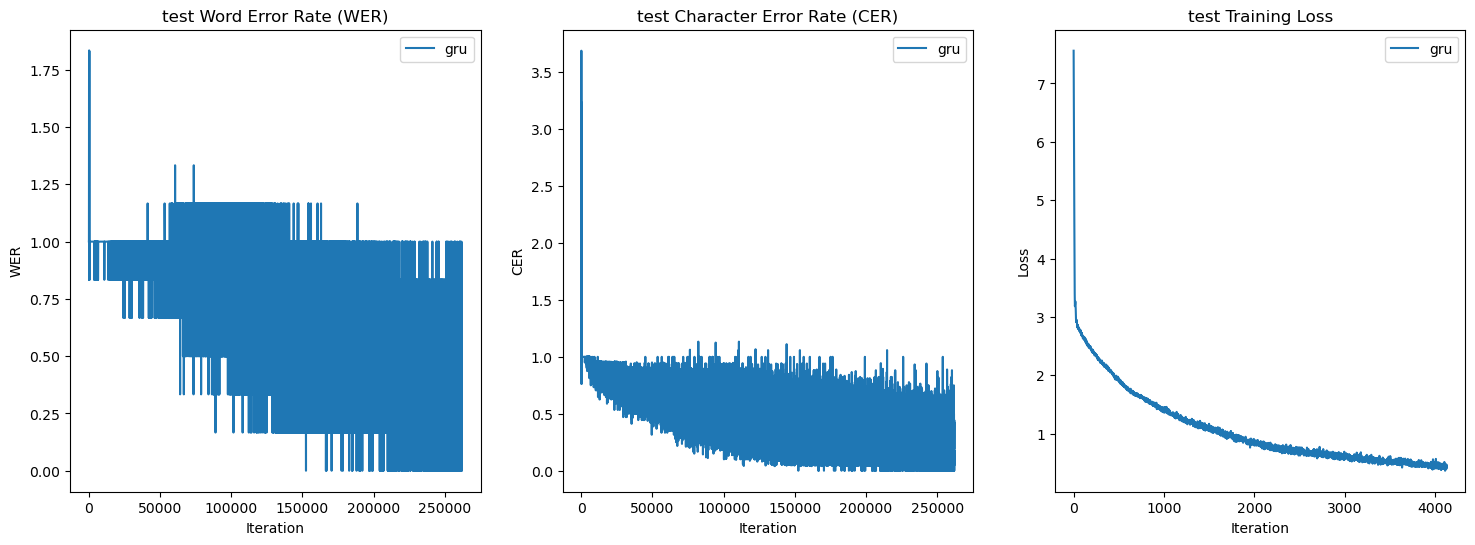

In [10]:
plot_error_curves_comparison(outputs)

In [ ]:
losses, lstm_WER, lstm_CER = train('lstm')
outputs.update({'lstm': {'train_wer': Lstm_WER, 'train_cer': Lstm_CER, 'train_loss': losses}})

device:  cuda
data loaded
model loaded
start training...
Epoch [1/10], Iteration: 50, Loss: 2.896, WER: 1.000, CER: 1.073
Epoch [1/10], Iteration: 100, Loss: 2.810, WER: 1.000, CER: 1.037
Epoch [1/10], Iteration: 150, Loss: 2.704, WER: 1.000, CER: 1.024
Epoch [1/10], Iteration: 200, Loss: 2.634, WER: 0.999, CER: 1.006
Epoch [1/10], Iteration: 250, Loss: 2.531, WER: 0.999, CER: 0.990
Epoch [1/10], Iteration: 300, Loss: 2.380, WER: 0.999, CER: 0.975
Epoch [1/10], Iteration: 350, Loss: 2.291, WER: 0.999, CER: 0.963
Epoch [1/10], Iteration: 400, Loss: 2.175, WER: 0.999, CER: 0.952
Evaluation Loss: 1.000, eval WER: 2.136, eval CER: 1.000
Epoch [2/10], Iteration: 450, Loss: 2.084, WER: 0.999, CER: 0.940
Epoch [2/10], Iteration: 500, Loss: 1.992, WER: 0.998, CER: 0.929
Epoch [2/10], Iteration: 550, Loss: 1.937, WER: 0.997, CER: 0.917
Epoch [2/10], Iteration: 600, Loss: 1.846, WER: 0.996, CER: 0.905
Epoch [2/10], Iteration: 650, Loss: 1.781, WER: 0.995, CER: 0.893
Epoch [2/10], Iteration: 700,

NameError: name 'Lstm_WER' is not defined

In [15]:
outputs.update({'lstm': {'train_wer': lstm_WER, 'train_cer': lstm_CER, 'train_loss': losses}})

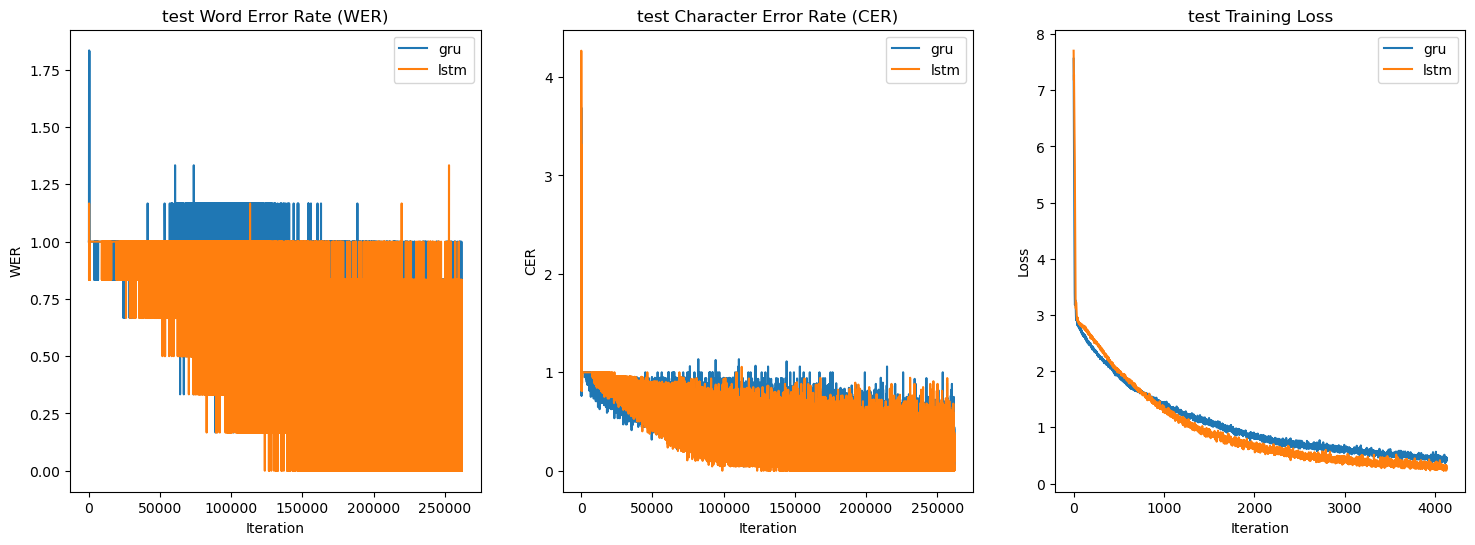

In [18]:

def plot_error_curves(output, mode='test'):
    iters = len(output['gru']['train_wer'])
    plt.figure(figsize=(18, 6)) #   (width, height)
    # plot WER
    plt.subplot(131)    # 1 row, 2 cols, subplot 1
    for i, k in enumerate(output):
        plt.plot(range(len(output[k]['train_wer'])), output[k]['train_wer'], label=k)
    plt.title('{} Word Error Rate (WER)'.format(mode))
    plt.xlabel('Iteration')
    plt.ylabel('WER')
    plt.legend()    

    # plot CER
    plt.subplot(132)    # 1 row, 2 cols, subplot 2
    for i, k in enumerate(output):
        plt.plot(range(len(output[k]['train_cer'])), output[k]['train_cer'], label=k)
    plt.title('{} Character Error Rate (CER)'.format(mode))
    plt.xlabel('Iteration')
    plt.ylabel('CER')
    plt.legend()

    # plot training loss
    plt.subplot(133)    # 1 row, 2 cols, subplot 3
    for i, k in enumerate(output):
        plt.plot(range(len(output[k]['train_loss'])), output[k]['train_loss'], label=k)
    plt.title('{} Training Loss'.format(mode))
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    
plot_error_curves(outputs)